In [91]:
import pandas as pd
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt
from matplotlib import style
import matplotlib
import numpy as np

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

df = pd.read_csv('../data/raw/basketball possessions.csv')
try:
    df = df.drop('Unnamed: 0',axis=1)
except:
    pass


In [92]:
def pred_shot_quality(df):
    pbp_df = pd.read_csv('../data/interim/cleaned_pbp_data.csv')
    pbp_df = pbp_df[['possessionId','Possession_Value']]
    
    df = df.merge(pbp_df,on='possessionId',how='left')
    df = df.sort_values(by='Possession_Value',ascending=False).drop_duplicates('possessionId',keep='first')
    
    df = df[df['shotX']!=0]
    df = df.reset_index()
    df = df.drop('index',axis=1)
    
    X = df[['sob','ato','zone','shortClock','press','pickAndRoll','hardDouble']]
    y = df[['Possession_Value']]
    
    y = y.fillna(y.mean())
    X = X.fillna(0)
    
    print(X.isnull().sum().sum())
    print(y.isnull().sum().sum())
    
    from sklearn.linear_model import ElasticNet
    
    elastic=ElasticNet(l1_ratio=0.5)
    elastic.fit(X,y)
    
    my_predict = elastic.predict(X)
    
    df['ppp_sq_val'] = my_predict
    print(my_predict)
    return df

In [93]:
##########################
df = pred_shot_quality(df)
##########################  

0
0
[0.91678276 0.91678276 0.91678276 ... 0.91678276 0.91678276 0.91678276]


In [71]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [72]:
# Probably a scatter w/ color corresponding to PPP value
def get_team_from_id(df,team_id):
    for idx,row in df.iterrows():
        df.at[idx,'gameResults.awayTeamId']=row['gameResults.awayTeamId'].strip()
        
    df=df[df['gameResults.awayTeamId']==team_id]
    df=df.reset_index()
    team_str = df['gameResults.awayTeamName'].iat[0]
    return team_str

def get_player_from_id(df,player_id,off_flag):
    for idx,row in df.iterrows():
        df.at[idx,'oPlayer.playerId']=row['oPlayer.playerId'].strip()
        df.at[idx,'dPlayer.playerId']=row['dPlayer.playerId'].strip()
    
    if off_flag:
        df=df[df['oPlayer.playerId']==player_id]
        df=df.reset_index()
        player_str = df['oPlayer.name'].iat[0]
    else:
        df=df[df['dPlayer.playerId']==player_id]
        df=df.reset_index()
        player_str = df['dPlayer.name'].iat[0]
        
    return player_str

def get_game_from_id(df,game_id):
    for idx,row in df.iterrows():
        df.at[idx,'gameResults.gameId']=row['gameResults.gameId'].strip()
    
    df=df[df['gameResults.gameId']==game_id]
    df=df.reset_index()
    home_team = df['gameResults.homeTeamName'].iat[0]
    away_team = df['gameResults.awayTeamName'].iat[0]
    
    game_str = f'{home_team} vs. {away_team}'
    
    return game_str
    
def plot_ppp_scatter(df,team_id='',game_id='',player_id='',off_flag=True,filename='default'):
    df['KEEP']=True
    for idx,row in df.iterrows():
        if row['shotX']==0:
            if row['shotY']==0:
                df.at[idx,'KEEP']=False
                
    df = df[df['KEEP']==True]
    df = df.drop('KEEP',axis=1)
    df = df.reset_index()
    try:
        df = df.drop('index',axis=1)
    except:
        pass
            
    if team_id != '':
        if off_flag:
            for idx,row in df.iterrows():
                df.at[idx,'offense.teamId']=row['offense.teamId'].strip()
                
            
            df=df[df['offense.teamId']==team_id]
        else:
            for idx,row in df.iterrows():
                df.at[idx,'defense.teamId']=row['defense.teamId'].strip()
                
            
            df=df[df['defense.teamId']==team_id] 
 
    if game_id != '':
        for idx,row in df.iterrows():
            df.at[idx,'gameResults.gameId']=row['gameResults.gameId'].strip()
        df = df[df['gameResults.gameId']==game_id]
        
    if player_id != '':
        for idx,row in df.iterrows():
            df.at[idx,'oPlayer.playerId']=str(row['oPlayer.playerId']).strip()
            df.at[idx,'dPlayer.playerId']=str(row['dPlayer.playerId']).strip()
            
        if off_flag:
            df = df[df['oPlayer.playerId']==player_id]
        else:
            df = df[df['dPlayer.playerId']==player_id]
    
    lower_25 = float(df['ppp_sq_val'].quantile(0.15))
    lower_50 = float(df['ppp_sq_val'].quantile(0.40))
    lower_75 = float(df['ppp_sq_val'].quantile(0.50))
    
    print(f'Lower25: {lower_25}')
    print(f'Lower50: {lower_50}')
    print(f'Lower75: {lower_75}')
    
    df['shot_quality_color'] = ''
    if off_flag:
        for idx,row in df.iterrows():
            if row['ppp_sq_val'] <= lower_25:
                df.at[idx,'shot_quality_color'] = '#fc3503'
            elif row['ppp_sq_val'] <= lower_50:
                df.at[idx,'shot_quality_color'] = '#fcd303'
            elif row['ppp_sq_val'] <= lower_75:
                df.at[idx,'shot_quality_color'] = '#e3fc03'
            else:
                df.at[idx,'shot_quality_color'] = '#118f22'
    else:
        for idx,row in df.iterrows():
            if row['ppp_sq_val'] <= lower_25:
                df.at[idx,'shot_quality_color'] = '#118f22'
            elif row['ppp_sq_val'] <= lower_50:
                df.at[idx,'shot_quality_color'] = '#e3fc03'
            elif row['ppp_sq_val'] <= lower_75:
                df.at[idx,'shot_quality_color'] = '#fcd303'
            else:
                df.at[idx,'shot_quality_color'] = '#fc3503'
        
        
    plt.figure(figsize=(12,11))
    draw_court(outer_lines=True)
    plt.scatter(df['shotX']*1.08,df['shotY']*1.15,s=20,c=df['shot_quality_color'])
    plt.xlim(-250,250)
    plt.ylim(-50,425)
    
    if off_flag:
        of_txt = 'Offensive'
    else:
        of_txt = 'Defensive'
    
    
    if game_id != '':
        game_str = get_game_from_id(df,game_id)
        plt.title(f'{of_txt} Shot Chart | {game_str}',fontsize=24)
    elif player_id != '':
        player_str = get_player_from_id(df,player_id,off_flag)
        plt.title(f'{of_txt} Shot Chart | {player_str}',fontsize=24)
    elif team_id != '':
        team_str = get_team_from_id(df,team_id)
        plt.title(f'{of_txt} Shot Chart | {team_str}',fontsize=24)
    
    plt.savefig(f'../images/{filename}.jpg', transparent=False)
    
    return ppp_df

Lower25: 0.9066776889868651
Lower50: 0.9066776889868651
Lower75: 0.9066776889868651


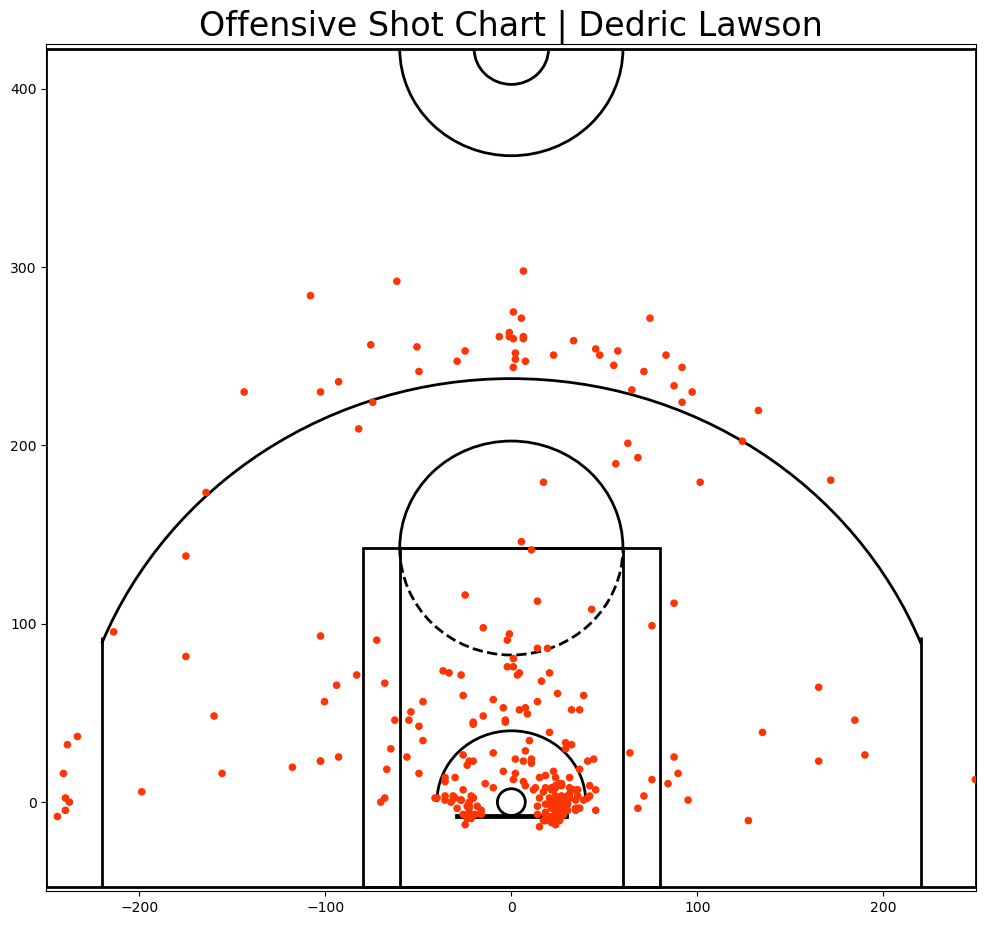

In [73]:
plot_ppp_scatter(df,team_id='',game_id='',player_id='59ed8bfef934491175f00a09',off_flag=True,filename='default')

In [74]:
#ppp_df = plot_ppp_scatter(df,player_id='a',off_flag = True)
#ppp_df